In [582]:
from comet_ml import Experiment

In [583]:
import numpy as np 
import shap
import pickle
import json
import time
import json
import pandas as pd
import torch
import math
import os
import xgboost 
import torch.nn as nn
import torch.nn.functional as F
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, auc
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

In [584]:
import sys
sys.path.append('../ift6758/visualizations/')
import question_7_plots
from question_7_plots import *

In [585]:
import importlib
importlib.reload(question_7_plots)


<module 'question_7_plots' from '/Users/krishnamaneeshad/ift6758/ift6758-project-template-main/notebooks/../ift6758/visualizations/question_7_plots.py'>

In [580]:
df = pd.read_csv('final_df.csv')

In [562]:
df_test = df[df['season'] == 20192020]
df_test_R = df_test[df_test['season_type'] == 'R']
df_test_P = df_test[df_test['season_type'] == 'P']

In [563]:
rf = pickle.load(open("random_forest", 'rb'))
xgb = pickle.load(open("XGBoost_hmtuning_model_v2.pickle",'rb'))
log1 = pickle.load(open("LogisticRegression_distance", 'rb'))
log2 = pickle.load(open("LogisticRegression_angle", 'rb'))
log3 = pickle.load(open("LogisticRegression_distance+angle", 'rb'))

## Features for RF

In [564]:
old_feat = ['game_id', 'season', 'season_type', 'event_id', 'home_team',
       'away_team', 'home_team_side_1st_period', 'attacking_team',
       'attacking_player', 'goalie', 'period', 'period_time', 'goal_ind',
       'shot_ind', 'x_coordinates', 'y_coordinates', 'shot_type', 'empty_net',
       'strength', 'gwg', 'previous_event_x_coordinates',
       'previous_event_y_coordinates', 'previous_event_period_time',
       'previous_event_type', 'previous_event_period', 'previous_attacking_team',
       'attacking_team_side']

df_feat = df.iloc[:,:60].columns.tolist()

RF_feat = [feat for feat in df_feat if feat not in old_feat]

## Features for XGBoost

In [565]:
feat_xgb = ['game_seconds', 'period', 'x_coordinates', 'y_coordinates',
       'distance_from_net', 'angle_from_net', 'previous_event_type',
       'previous_event_x_coordinates', 'previous_event_y_coordinates',
       'time_since_last_event', 'distance_from_last_event', 'rebound',
       'change_in_angle', 'speed', 'time_since_powerplay_started', '5v5',
       '4v4', '3v3', '5v4', '5v3', '4v3', '4v5', '3v5', '3v4',
       'shot_type_Backhand', 'shot_type_Deflected', 'shot_type_Slap Shot',
       'shot_type_Snap Shot', 'shot_type_Tip-In', 'shot_type_Wrap-around',
       'shot_type_Wrist Shot']

def preprocess(df):
    le = LabelEncoder()
    df["previous_event_type"] = le.fit_transform(df["previous_event_type"])
    
    return df

le_name_mapping = {'Blocked Shot': 0, 'Faceoff': 1, 'Game Official': 2, 'Giveaway': 3, 'Goal': 4, 'Hit': 5, 'Missed Shot': 6, 'Official Challenge': 7, 'Penalty': 8, 'Period End': 9, 'Period Official': 10, 'Period Ready': 11, 'Period Start': 12, 'Shootout Complete': 13, 'Shot': 14, 'Stoppage': 15, 'Takeaway': 16}

## Assign the proper features to each model

In [566]:
X_rf = df_test_R[RF_feat]
X_rf_P = df_test_P[RF_feat]

X_xgb = preprocess(df_test_R[feat_xgb])
X_xgb["previous_event_type"] = X_xgb["previous_event_type"].replace(le_name_mapping)
X_xgb_P = preprocess(df_test_P[feat_xgb])
X_xgb_P["previous_event_type"] = X_xgb_P["previous_event_type"].replace(le_name_mapping)

X_lr_D = df_test_R['distance_from_net'].values.reshape(-1,1)
X_lr_D_P = df_test_P['distance_from_net'].values.reshape(-1,1)

X_lr_A = df_test_R['angle_from_net'].abs().values.reshape(-1,1)
X_lr_A_P = df_test_P['angle_from_net'].abs().values.reshape(-1,1)

X_lr_DA = df_test_R[['distance_from_net','angle_from_net']]
X_lr_DA_P = df_test_P[['distance_from_net','angle_from_net']]

y = df_test_R['goal_ind']
y_P = df_test_P['goal_ind']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Prediction for regular season 

In [567]:
# Random Forest
preds_rf = rf.predict(X_rf)

# XGBoost
preds_xgb = xgb.predict(X_xgb)

# Logistic regression with Distance
preds_lr_d = log1.predict(X_lr_D)

# Logistic regression with Angle
preds_lr_a = log2.predict(X_lr_A)

# Logistic regression with Distance & Angle (Baseline)
preds_lr_da = log3.predict(X_lr_DA)

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- shot_type_Wrist Shot
Feature names seen at fit time, yet now missing:
- Unnamed: 0

X has feature names, but LogisticRegression was fitted without feature names


# Prediction Probabilities

In [568]:
# Random Forest
preds_proba_rf = rf.predict_proba(X_rf)
# XGBoost
# preds_proba_xgb = xgb.predict_proba(X_xgb)
# Logistic regression with Distance
preds_proba_lr_d = log1.predict_proba(X_lr_D)
# Logistic regression with Angle
preds_proba_lr_a = log2.predict_proba(X_lr_A)
# Logistic regression with Distance & Angle (Baseline)
preds_proba_lr_da = log3.predict_proba(X_lr_DA)

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- shot_type_Wrist Shot
Feature names seen at fit time, yet now missing:
- Unnamed: 0

X has feature names, but LogisticRegression was fitted without feature names


## Accuracy and ROC for logistic regression models

In [569]:
accuracy_lrd = accuracy_score(y,preds_lr_d)
roc_auc_lrd =  roc_auc_score(y,preds_lr_d)
accuracy_lra = accuracy_score(y,preds_lr_a)
roc_auc_lra =  roc_auc_score(y,preds_lr_a)
accuracy_lrda = accuracy_score(y,preds_lr_da)
roc_auc_lrda =  roc_auc_score(y,preds_lr_da)

## Accuracy and ROC for Random Forest

In [570]:
accuracy_rf = accuracy_score(y,preds_rf)
roc_auc_rf =  roc_auc_score(y,preds_rf)
report_rf = classification_report(y, preds_rf, output_dict=True)

In [571]:
roc_auc_rf

0.5002738370823617

## Accuracy and ROC for XGBoost

In [572]:
accuracy_xgb = accuracy_score(y,preds_xgb)
roc_auc_xgb =  roc_auc_score(y,preds_xgb)
report_xgb = classification_report(y, preds_xgb, output_dict=True)

## Plots for regular season

In [573]:
## Dataframe with ground truth labels from Test set and the the prediction probabilities from each of the models
df_prob = pd.DataFrame({"goal_ind":y, "preds_proba_rf": preds_proba_rf[:,1], "preds_proba_lr_da": preds_proba_lr_da[:,1],"preds_proba_lr_a": preds_proba_lr_a[:,1],"preds_proba_lr_d": preds_proba_lr_d[:,1], "preds_proba_xgb": preds_proba_xgb[:,1] })
df_prob['shot_count'] = 1


In [574]:
model_list = ["Random Forest", "Logistic Regression with distance and angle", 
"Logistic Regression with angle","Logistic Regression with distance"] # ,"XGBoost"]
df_prob.columns


Index(['goal_ind', 'preds_proba_rf', 'preds_proba_lr_da', 'preds_proba_lr_a',
       'preds_proba_lr_d', 'shot_count'],
      dtype='object')

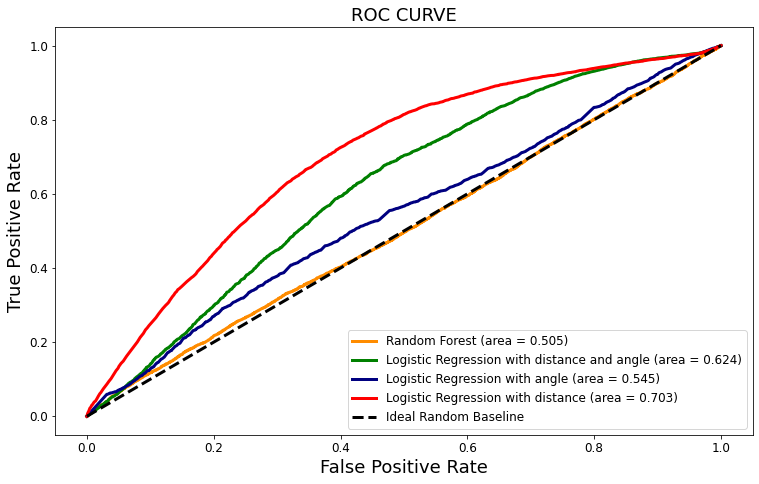

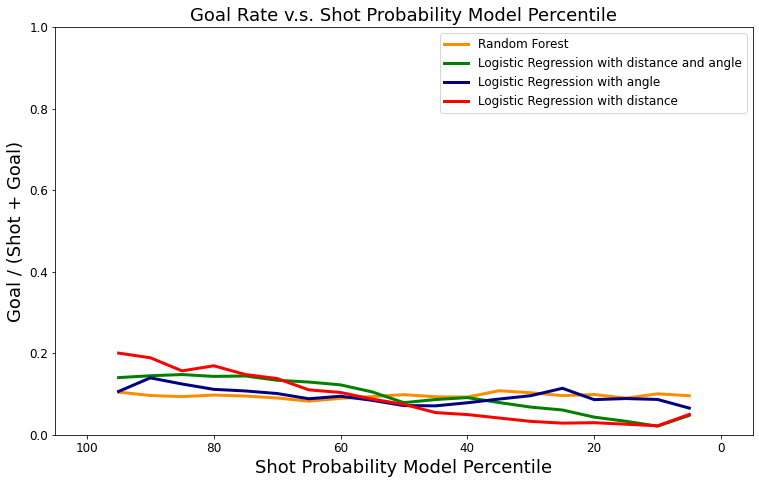

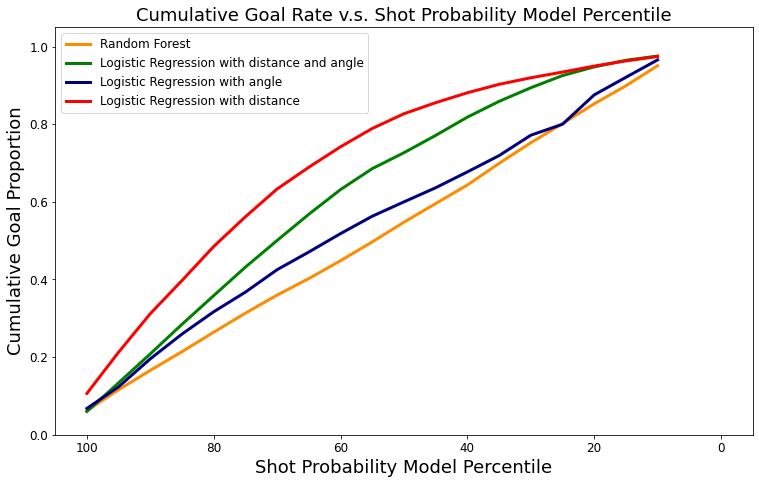

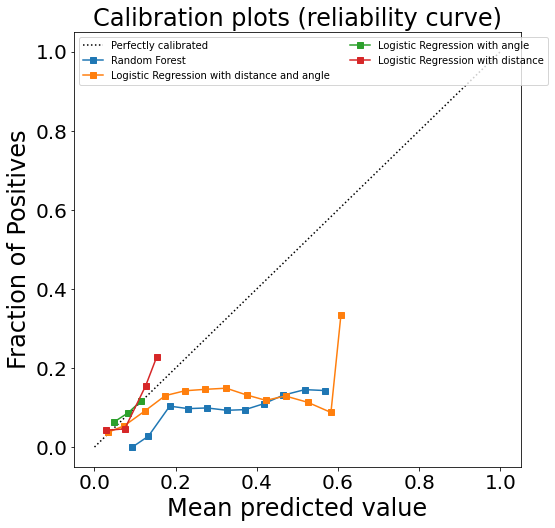

In [589]:
roc = get_roc_auc_plot(df_prob = df_prob, list_labels = model_list)

grp = get_goal_rate_plot(df_prob = df_prob, list_labels = model_list)

crp = get_cum_rate_plot(df_prob = df_prob, list_labels = model_list)

calib = get_calibration_plot(df_prob = df_prob, list_labels = model_list)

## Predictions for playoffs

In [373]:
preds_rf_p = rf.predict(X_rf_P)
# preds_xgb_p = xgb.predict(X_xgb_P)
preds_lr_d_p = log1.predict(X_lr_D_P)
preds_lr_a_p = log2.predict(X_lr_A_P)
preds_lr_da_p = log3.predict(X_lr_DA_P)

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- shot_type_Wrist Shot
Feature names seen at fit time, yet now missing:
- Unnamed: 0

X has feature names, but LogisticRegression was fitted without feature names


## Prediction Probabilities

In [374]:
# Random Forest
preds_proba_rf_p = rf.predict_proba(X_rf_P)
# XGBoost
# preds_proba_xgb_p = xgb.predict_proba(X_xgb_P)
# Logistic regression with Distance
preds_proba_lr_d_p = log1.predict_proba(X_lr_D_P)
# Logistic regression with Angle
preds_proba_lr_a_p = log2.predict_proba(X_lr_A_P)
# Logistic regression with Distance & Angle (Baseline)
preds_proba_lr_da_p = log3.predict_proba(X_lr_DA_P)

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- shot_type_Wrist Shot
Feature names seen at fit time, yet now missing:
- Unnamed: 0

X has feature names, but LogisticRegression was fitted without feature names


## Accuracy and ROC for logistic regression models - playoffs

In [375]:
accuracy_lrd_p = accuracy_score(y_P,preds_lr_d_p)
roc_auc_lrd_p =  roc_auc_score(y_P,preds_lr_d_p)
accuracy_lra_p = accuracy_score(y_P,preds_lr_a_p)
roc_auc_lra_p =  roc_auc_score(y_P,preds_lr_a_p)
accuracy_lrda_p = accuracy_score(y_P,preds_lr_da_p)
roc_auc_lrda_p =  roc_auc_score(y_P,preds_lr_da_p)

## Accuracy and ROC for Random Forest - playoffs

In [376]:
accuracy_rf_p = accuracy_score(y_P,preds_rf_p)
roc_auc_rf_p =  roc_auc_score(y_P,preds_rf_p)
report_rf_p = classification_report(y_P, preds_rf_p, output_dict=True)

## Accuracy and ROC for XGBoost - playoffs

In [16]:
accuracy_xgb_p = accuracy_score(y_P,preds_xgb_p)
roc_auc_xgb_p =  roc_auc_score(y_P,preds_xgb_p)
report_xgb_p = classification_report(y_P, preds_xgb_p, output_dict=True)

## Plots for playoffs 

In [380]:
## Dataframe with ground truth labels from Test set and the the prediction probabilities from each of the models
df_prob_p = pd.DataFrame({"goal_ind":y_P, "preds_proba_rf": preds_proba_rf_p[:,1], "preds_proba_lr_da": preds_proba_lr_da_p[:,1],"preds_proba_lr_a": preds_proba_lr_a_p[:,1],"preds_proba_lr_d": preds_proba_lr_d_p[:,1]}) # "preds_proba_xgb": preds_proba_xgb_p[:,1] })
df_prob_p['shot_count'] = 1


In [587]:
# model_list = ["Random Forest", "Logistic Regression with distance and angle", 
# "Logistic Regression with angle","Logistic Regression with distance"] # ,"XGBoost"]
df_prob_p.columns


Index(['goal_ind', 'preds_proba_rf', 'preds_proba_lr_da', 'preds_proba_lr_a',
       'preds_proba_lr_d', 'shot_count'],
      dtype='object')

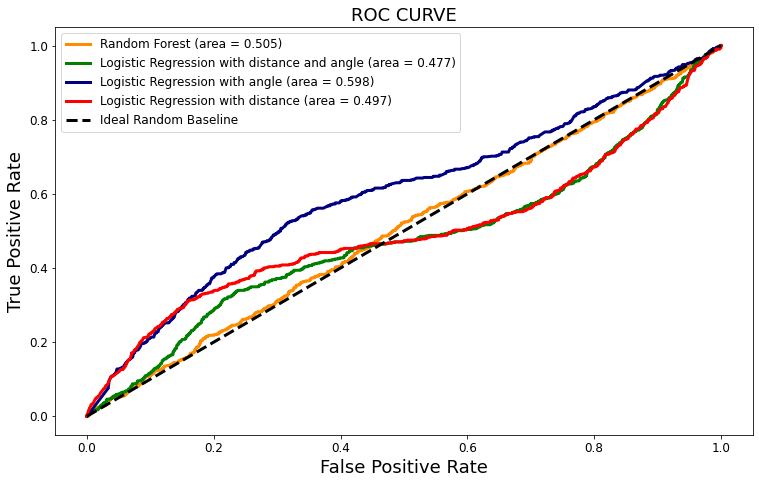

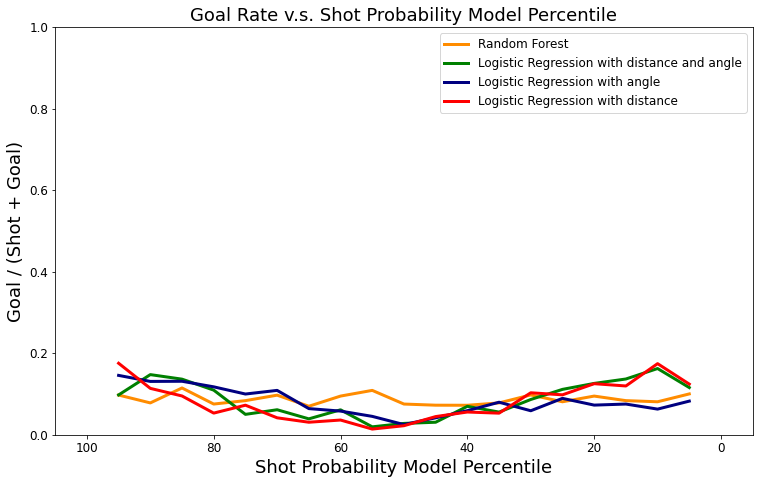

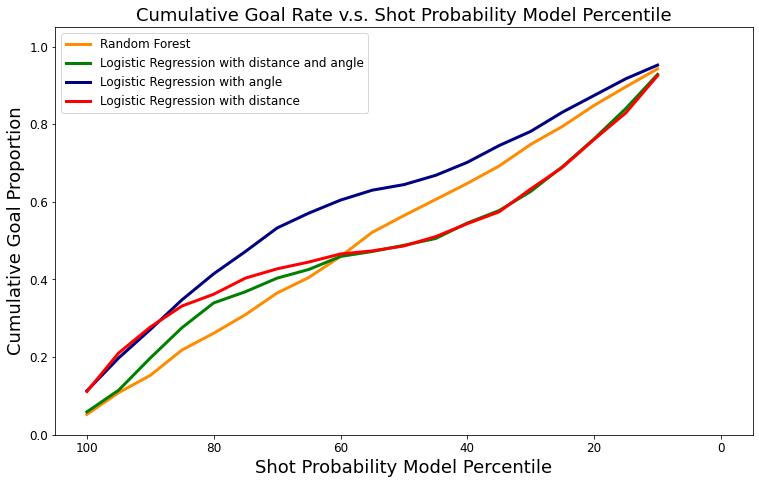

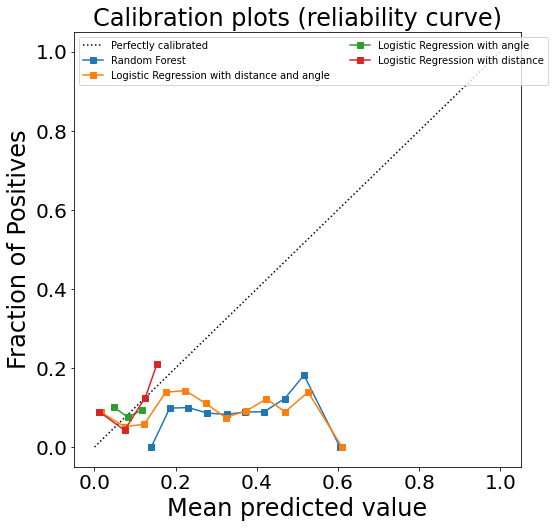

In [588]:
roc_p = get_roc_auc_plot(df_prob = df_prob_p, list_labels = model_list)

grp_p = get_goal_rate_plot(df_prob = df_prob_p, list_labels = model_list)

crp_p = get_cum_rate_plot(df_prob = df_prob_p, list_labels = model_list)

calib_p = get_calibration_plot(df_prob = df_prob_p, list_labels = model_list)